# Importing Relevant Python Libraries

In [3]:
import pandas as pd
import numpy as np 
import sklearn as sk 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.ndimage.interpolation import shift
from datetime import date, timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats

# Signal Generation Functions

## Rolling Window Fitting Method (described in 4.2 of the Thesis)
This function takes the following inputs:
- start: numerical index reprsenting the first point within the input dataset X that is to be predicted and hence belongs to the test set
- end: numerical index representing the last point within the input dataset X that is to be predicted
- X: numpy array of the input values to train the model with -> in most of the examples in this code base the input array X is the log returns of the asset being used to train the HMM
- states: number of hidden states that is a hyperparamter to give to the HMMs
- window: length of the window (only applicable if the rolling fit method is used)
- delay: a counter threshold that represents the number of periods in a row that a regime prediction must assume before the function officially predicts a state change -> allows for smoothing of the trading signal if there are large number of regime switching predictions
- seed: seed value for random number generation

## Expanding Window Fitting Method (described in 4.2 of the Thesis)
This function requires the same inputs above less the window variable since the window in this case is expanding and not limited to a specific windowed number of historical observations

In [7]:
# code generating out-of-sample test set trading signal applying Method 4.4's Counter Algorithm
# The "delay" variable is equal to the counter threshold 

def generate_signal_rolling(start, end, X, states, window, delay, seed):
    
    # setting the random seed
    np.random.seed(seed)
    
    # initialising an empty list to store the generated trading signal
    signal = []
    
    # initialising a counter value to 0 which will count up to the "delay" variable before telling the strategy to change 
    # state
    count = 0
    
    # reshaping the input numpy array
    X = X.reshape(-1, 1)
    
    # initialising Gaussian HMM using HMMLearn
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    
    # fitting the HMM model with a windowed number of historical observations taking place before the start index all the way
    # up to the start index in the numpy array - predicts the first day of the test set
    model.fit(X[start-window:start])
    
    # using the model to predict after fitting it
    predictions = model.predict(X[start-window:start])
    
    # appending the prediction to a list called signal which stores the final output signal
    signal.append(predictions[-1])
    
    # storing the prediction as a temporary variable that can be checked
    prev_pred = predictions[-1]
    
    # for loop iterating through the entire test set
    for i in range(1, end-start):
        
        # fitting the model on each iteration of the test set - hence earning the name "rolling fit"
        model.fit(X[start-window+i:start+i])
        
        # predicting the model
        predictions = model.predict(X[start-window+i:start+i])
        
        # storing the predicting in a temporary variable that is reset on each iteration
        pred = predictions[-1]
        
        # if prediction is the same as the previous prediction, increment the counter (counter threshold algorithm)
        if pred == prev_pred:
            count = count + 1 
         
        # if prediction doesn't equal previous prediction, reset counter to 1
        elif pred != prev_pred:
            count = 1
         
        # if counter is greater than or equal to the counter threshold "delay", append that prediction to the signal
        if count >= delay:
            signal.append(pred)
         
        # if the counter is below the threshold, keep appending the last previous prediction to the signal
        elif count < delay:
            signal.append(signal[-1])
        
        # setting the previous prediction to the current prediction, making room for pred to be reset in the next loop
        prev_pred = pred
      
    # if the signal contains more 0's than 1's then flip the signal. It is implied that the bull state occurs more often 
    # than the bear state hence we want 1's to represent the bull state and 0's to represent the bear state
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
     
    # if more 1's than 0's then just return the signal as a numpy array
    else: 
        signal = np.array(signal)
        
    # return signal    
    return signal

def generate_signal_expanding(start, end, X, states, threshold, seed):
    # setting the random seed
    np.random.seed(seed)
    
    # initialising an empty list to store the generated trading signal
    signal = []
    
    # initialising a counter value to 0 which will count up to the "delay" variable before telling the strategy to change 
    # state
    count = 0
    
    # reshaping the input numpy array
    X = X.reshape(-1, 1)
    
    # initialising Gaussian HMM using HMMLearn
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
            
    # fitting the model with all the values up to the start index
    model.fit(X[:start])
                  
    # using the fitted model to predict
    predictions = model.predict(X[:start])
    
    # appending the prediction to the signal vector
    signal.append(predictions[-1])
    
    # storing the prediction as a temporary variable that can be checked
    prev_pred = predictions[-1]
    
    # for loop iterating through the entire test set
    for i in range(1, end-start):
        
        # fitting the model on each iteration of the test set - hence earning the name "rolling fit"
        model.fit(X[:start+i])
        
        # predicting the model
        predictions = model.predict(X[:start+i])
                  
        # storing the predicting in a temporary variable that is reset on each iteration
        pred = predictions[-1]
        
        # if prediction is the same as the previous prediction, increment the counter (counter threshold algorithm)
        if pred == prev_pred:
            count = count + 1 
         
        # if prediction doesn't equal previous prediction, reset counter to 1
        elif pred != prev_pred:
            count = 1
         
        # if counter is greater than or equal to the counter threshold "delay", append that prediction to the signal
        if count >= delay:
            signal.append(pred)
         
        # if the counter is below the threshold, keep appending the last previous prediction to the signal
        elif count < delay:
            signal.append(signal[-1])
        
        # setting the previous prediction to the current prediction, making room for pred to be reset in the next loop
        prev_pred = pred
      
    # if the signal contains more 0's than 1's then flip the signal. It is implied that the bull state occurs more often 
    # than the bear state hence we want 1's to represent the bull state and 0's to represent the bear state
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
     
    # if more 1's than 0's then just return the signal as a numpy array
    else: 
        signal = np.array(signal)
        
    # return signal    
    return signal

## Cash Back-test Function

A straightforward back-testing methodology that makes two decisions based on bi-modal signal:
- when long convert all cash into continous units of stock and set cash equal to 0
- when short convert all continous units of stock into cash and set continous units of stock to 0
- returns a portfolio equity curve that is the portfolio value of the strategy at each time point

The required inputs for the function are:
- price: the NEXT DAY's OPEN price -> since the computation requires the previous day's CLOSE price, it cannot be used since the market closes once that price is finalised. Hence, the next available price that an algorithm could trade on is the open price of the next day
- signal: the output trading signal from the HMM functions: generate_signal_rolling() and generate_signal_expanding(). Any trading signal of 1's and 0's can be used in this section alongside the relevant next day open price on which it was generated. 

In [8]:
def backtest_signal(price, signal):
    
    # initialising a numpy array to hold all the continous units of the asset that the strategy will buy up
    w = np.zeros(np.shape(price))
    
    # initialising a numpy array to hold all the values of the cash that the strategy will have at each time point
    cash = np.zeros(np.shape(price))
    
    # initialising first value of the cash
    cash[0] = 10000

    # iterating through each price
    for i in range(0, len(price)):

        # since next day open values are used as the price being traded, the final value is missing 
        if i == len(price)-1:
            break

        # if signal is 1, convert all cash to continous units and set cash equal to 0
        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i]  + w[i]
            cash[i+1] = 0

        # if signal is 0, convert all units to cash, and set continuous unit to 0
        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i] + cash[i]
            w[i+1] = 0
     
    # obtain portfolio equity curve at the end of back-test to get portfolio value throughout the strategy at each time point
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    # return the back-tested portfolio vector
    return strat

## Performance Ratios Functions
This section contains functions taht help in calculating the performance ratios required in this thesis. 
The inputs defined in this section are as follows:
- strat: this is the numpy array output of cash_backtest() -> a back-tested equity curve of the portfolio running the trading signal generated previously. It is a time series thet represents the portfolio value at each time point of the test set. 
- returns: this is a numpy array that represents the returns of the strategy's portfolio equity curve "strat". Running log_returns() on strat leads to the calculation of "returns"

The 3 functions at the bottom were used to print relevant results in a quicker fashion. 

The function plot_highlighted_graph() is a key function for presenting results in this research. The function takes the input signal and plots it over the normalised next day open price of an asset. It highlights the region the signal is short as red, and long as green. It gives a visual indication for how well the strategy predicts market events. 
It takes in 2 additional inputs:
- threshold: this represents a percentage. Price movements greater than this % will be plotted on the resulting output graph in this function. The rationale behind choosing threshold to be between 15-20% and plotting it is to represent regions of the price where big shifts and arguably "regime changes" occurred. The points are plotted to visually see if the HMM detected these recognisable price deviations. 
- string: this is the string name that saves the output plot from the plot_highlighted_graph() function

In [9]:
def log_returns(strat):
    returns = np.log(shift(strat, -1)/strat)
    returns = np.delete(returns, -1)
    return returns

def sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(252), 3)

def sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(252), 3)

def max_dd(data):
    p = np.argmax(np.maximum.accumulate(data) - data)
    q = np.argmax(data[:p])
    max_drawdown = (data[p]-data[q])/data[q]
    return np.round(abs(max_drawdown), 3)

def calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

def absolute_return(price):
    abs_ret = (price[-1] - price[0])/price[0]
    annual_abs_ret = abs_ret/(len(price)/252)
    return annual_abs_ret

def ann_vol(price):
    # takes input price as numpy array
    vol = np.std(log_returns(price))
    annual_vol = vol * np.sqrt(252)
    return annual_vol
    
def print_ann_ret(strat, price):
    print("Strategy Annualised Return:", round(absolute_return(strat),3), sep='\n')
    print("Asset Annualised Return:", round(absolute_return(price.values),3), sep='\n')
    
    print("Strategy Annualised Vol:", round(ann_vol(strat),3), sep='\n')
    print("Asset Annualised Vol:", round(ann_vol(price.values),3), sep='\n')

def print_ratios(strat, price):
    print("Strategy:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(strat)),
    sortino(log_returns(strat)),
    calmar(log_returns(strat), strat))
    print("Asset:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(price.values)),
    sortino(log_returns(price.values)),
    calmar(log_returns(price.values), price.values))
    print("\n")
    
def plot_highlighted_graph(price, threshold, signal, string):
    values, ids = dc(price, threshold)
    idx = price.index
    d = []

    for i in range(1, len(idx)-1):
        if signal[i] == signal[i+1]:
            pass
        else:
            d.append(idx[i])

    d.append(idx[-1])

    plt.figure(figsize=(12,4))
    plt.title("Long (green) and Short (red) Regions of Price Output by HMM Model: Rolling Window", fontsize=18)
    plt.ylabel("Price", fontsize=18)
    plt.xlabel("Date", fontsize=18)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.plot(idx, price)
    plt.xticks(rotation=45)
    plt.scatter(idx[ids], values, s=200, c='r')

    if signal[0] == 1:
        plt.axvspan(idx[0], d[0], facecolor='g', alpha=0.5)  
        for i in range(0, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='r', alpha=0.5)
        for i in range(1, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='g', alpha=0.5)
    plt.tight_layout()
    #plt.grid()
    plt.savefig(string)
    plt.show() 

## DC Points Functions
This function calculates the Directional Change (DC) points described in Tsang and Chen's book "Detecting Regime Change in Computational Finance". The methodology of how these points are calculated is described in the book as well as in Chapter 2.5 of the Thesis. 

The outputof this function are the values of the price points where directional changes occur in the price and also the index points at which these happen. The index points are what is used throughout this research to mark areas where significant price movements occur (equal to a threshold percentage which is taken as an input). These markings are left so that it is visible where the most significant market price movements occur, and it can then be seen whether or not the HMMs predict regime changes at or near these large price movements as desired. 

This function requires inputs of:
- price: the input close price on which the DC points are calculated
- threshold: a percentage representing the magnitude of price movements that will be calculated and plotted

In [10]:
def dc(price, threshold):

    curr_min = price[0]
    curr_min_id = 0
    curr_max = price[0]
    curr_max_id = 0
    min_bool = False
    max_bool = False

    values = []
    ids = []

    for i in range(1, len(price)):


        if price[i] > curr_max:
            curr_max = price[i]
            curr_max_id = i


        elif price[i] < curr_min:
            curr_min = price[i]
            curr_min_id = i


        if abs((price[i] - curr_min)/curr_min) >= threshold and min_bool == False:
            # save values and now look for OS point
            values.append(curr_min)
            ids.append(curr_min_id)

            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            min_bool = True
            max_bool = False

        elif abs((price[i] - curr_max)/curr_max) >= threshold and max_bool == False:
            # save values and now look for OS point
            values.append(curr_max)
            ids.append(curr_max_id)
            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            max_bool = True
            min_bool = False


    if min_bool == True:
        values.append(curr_max)
        ids.append(curr_max_id)
        
    elif max_bool == True:
        values.append(curr_min)
        ids.append(curr_min_id)
    

    return values, ids

### Method 1 - The Rolling Window Fit Method (4.2-4.3 of the Thesis - Base Method with Counter Algorithm on top)

Example code of running method 1 wbich is the rolling window fit method. This is where the returns of an asset are fed into a HMM model one day at a time over the entire test set. At each point, a window passes over the input dataset; a windowed number of historical values are sliced and fed into the HMM with the next day being predicted. This goes on for each day of the test set.

1. First the data is imported via Yahoo Finance

2. The required input parameters are initialised

3. The input data is initialised

4. The signal is generated using the generate_signal_rolling() function

5. The signal is plotted 

6. The signal is backtested using the cash_backtest() function

7. The portfolio backtest vector is plotted

8. Performance metrics are calculated on the portfolio backtest vector

9. plot_highlighted_graph() is called whereby the signal is plotted on the backdrop of the normalised next day open price on which it is traded with the relevant DC points plotted indicating where significant market price movements occurred. The function highlights the regions where the signal is long as green and short as red. 

The same code can be run with generate_signal_rolling() replaced with generate_signal_expanding() and it will function the exact same.

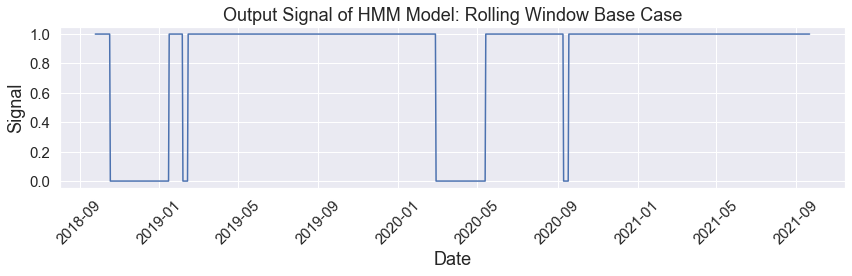

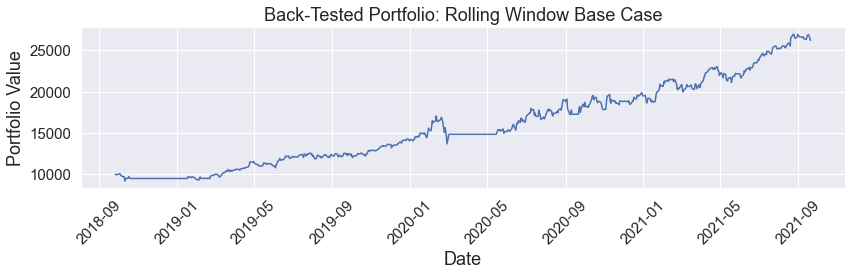

Strategy:
Sharpe | Sortino | Calmar Ratios
1.45 1.793 0.103
Asset:
Sharpe | Sortino | Calmar Ratios
1.187 1.553 0.075


Strategy Annualised Return:
0.544
Asset Annualised Return:
0.562
Strategy Annualised Vol:
0.223
Asset Annualised Vol:
0.279


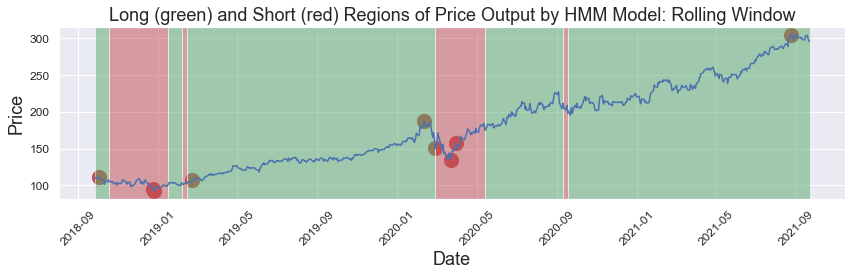

In [11]:
sns.set()

# 1 importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change().dropna()
msft = msft.dropna()
msft["Vol"] = msft["Returns"].rolling(5).std()
msft = msft.dropna()

# 2 initialising function parameters
start = 3017
end = len(msft)
window = 500
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# 3 initialising the input return series to feed the HMM
X = log_returns(msft["Close"].values)

# 4 SIGNAL GENERATION: CALLING THE ROLLING FIT FUNCTION
signal = generate_signal_rolling(start, end, X, states, window, delay, 22)

# 5 plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Rolling Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6 BACKTESTING THE SIGNAL: CALLING THE BACKTEST FUNCTION
strat = backtest_signal(price, signal)

# 7 plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Rolling Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8 printing performance ratios and annualised returns
print_ratios(strat, price)
print_ann_ret(strat, price)

# 9 plotting long and short graph
plot_highlighted_graph(price, threshold, signal, "S&P w delay (5) ret+vol Rolling window base result performance")

# Naive Bayes Classifier Code (described in 4.4 of the Thesis)

In [42]:
from scipy.stats import norm

def switch_signal(signal):
    """Takes an input signal as a numpy array or list and switches its values around if there are more 0's than 1's."""
    signal = list(signal)
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        return signal
    else: 
        signal = np.array(signal)
        return signal

def ret_df(signal, returns):
    """
    Takes 2 input signals as a numpy array or list representing a trading signal and the set of returns, adds them both
    to a dataframe and returns the dataframe. 
    """
    df = pd.DataFrame()
    df["Returns"] = returns
    df["Signal"] = signal
    return df

def ret_norm_params(var):
    """Takes the input of a variable called "var" and fits it to a normal distribution using SciPy and then returns the 
    fitted normal distributions mean and volatility.
    """
    params = norm.fit(var)
    mean = params[0]
    std_dev = params[1]
    return mean, std_dev

def NBC(predictions, X):
    """
    This function takes an input of an in-sample HMM predicted sequence "predictions" and a var "X" containing a numpy array
    holding the returns of the asset being predicted. 
    The function calculates the quantities described in subchapter 4.4 of the Thesis. The quantities are:
    - p_Cx: where x is 0 or 1 - this represents the frequentist probability of there being either a state 0 or 1 by dividing 
    the total number of each predicted state divided by the total number of predictions (frequency)
    - px_C0 & px_C1: where these quantities represent the likelihood the newest return value, "x", will have come from either
    the state 0 (short) fitted distribution or the state 1 (long) fitted distribution. It is obtained by fitting the returns 
    that pertain to each respective state (as predicted by the HMM), obtaining the Gaussian parameters, and then using norm_pdf()
    to make use of the parameters to give a likelihood that the current return value belongs to either state.
    - pC0_x & pC1_x: This is a normalised probability that the current return value belongs to either state 0 or state 1. It is the final
    output. 
    """
    # making sure more 1's than 0's
    predictions = switch_signal(predictions)
    predictions = predictions
    
    # calculating probability of either regime historically
    p_C0 = list(predictions).count(0)/len(predictions)
    p_C1 = list(predictions).count(1)/len(predictions)
    
    # returning df with returns and the signal
    df = ret_df(predictions, X)
    
    # obtaining returns from both states
    returns_0_state = df[df["Signal"] == 0]["Returns"]
    returns_1_state = df[df["Signal"] == 1]["Returns"]
    
    # fitting returns from both states to obtain parameters
    mean_0, std_0 = ret_norm_params(returns_0_state)
    mean_1, std_1 = ret_norm_params(returns_1_state)
    
    # fitting most recent return value to both distributions
    x = X[-1]
    
    # using norm pdf instead of manually creating norm dist
    px_C0 = norm.pdf(x, mean_0, std_0)
    px_C1 = norm.pdf(x, mean_1, std_1)
    
    
    # calculating the probability of the data
    px = px_C0*p_C0 + px_C1*p_C1
    
    # final output
    pC0_x = (p_C0*px_C0)/px
    pC1_x = (p_C1*px_C1)/px

    #probabilities = [px_C0, px_C1]
    probabilities = [pC0_x, pC1_x]
    
    return probabilities

def generate_signal_expanding_w_NBC(start, end, X, states, delay, seed):
    """
    This function is similar to the generate_signal_rolling() or generate_signal_expanding() function but is adapted so that
    instead of checking whether the predictions are continous and surpass a threshold counter value, this function checks if 
    the predicted value is the same as the predicted state from the NBC probability output. 
    Case 1: If the most likely state from the NBC
    is the same as the predicted state, then the algorithm outputs that state. 
    Case 2: If the two quantities are not the same then the 
    value predicted by the NBC is preferred and used instead.
    """
    # initialising seed, parameters, and reshaping the input returns to the shape required by the HMM
    np.random.seed(seed)
    signal = []
    count = 0
    NBC_count = 0
    NBC_preds = []
    X_reshape = X.reshape(-1, 1)
    
    # initialising the model
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    
    # fitting the model
    model.fit(X_reshape[:start])
    
    # predicting the mdoel
    predictions = model.predict(X_reshape[:start])
    
    # calculating the NBC probabilities
    p = NBC(predictions, X[:start])
    
    # storing the NBC probabilities and the prediction
    NBC_preds.append((p, predictions[-1]))
    
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        # fitting the model on each iteration of the for loop (required so that up to date predictions are fed to the NBC)
        model.fit(X_reshape[:start+i])
        
        # obtaining the predictions
        predictions = model.predict(X_reshape[:start+i])
        
        # storing the prediction for the next day in pred
        pred = predictions[-1]
        
        # obtaining the probabilities from the NBC for this set of predictions 
        p = NBC(predictions, X[:start+i])
        
        # storing the NBC probabilities and the HMM prediction in a list called NBC_preds
        NBC_preds.append((p, pred))
        
        # CASE 1
        if pred == np.argmax(NBC_preds[i][0]):
            signal.append(pred)
            
        # CASE 2    
        else:
            signal.append(np.argmax(NBC_preds[i][0]))
            
            # variable storing the number of times the NBC was sided with compared to the HMM's prediction output
            NBC_count = NBC_count + 1

    # switching the signal if there are more 0's than 1's such that the signal corresponds to 1 representing long and 0 
    # representing short
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal, NBC_count, NBC_preds

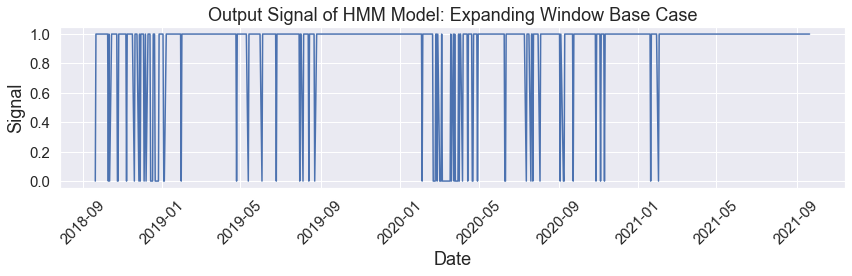

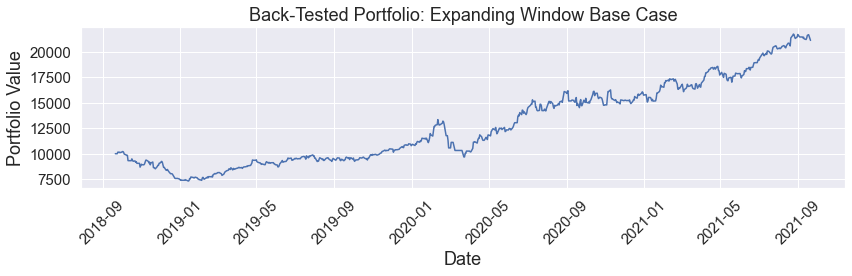

Strategy:
Sharpe | Sortino | Calmar Ratios
1.008 1.232 0.057
Asset:
Sharpe | Sortino | Calmar Ratios
1.189 1.557 0.075


Strategy Annualised Return:
0.371
Asset Annualised Return:
0.564
Strategy Annualised Vol:
0.248
Asset Annualised Vol:
0.278


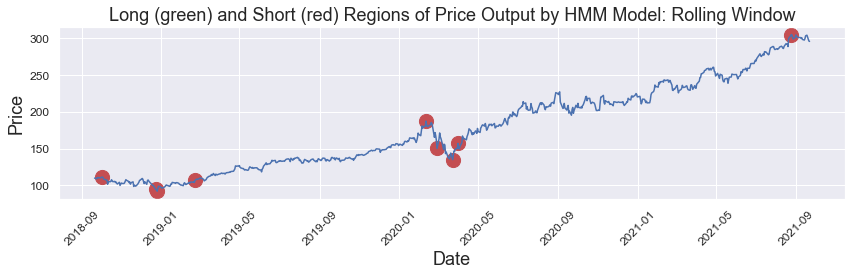

In [43]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal, nc, ncp = generate_signal_expanding_w_NBC(start, end, X, states, delay, 2200)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Expanding Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Expanding Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, signal, "expanding window base result performance")

# Cross Validating Different Windows Sizes Using the Rolling Fit Method Across Various Market Downturns/Crashes (described in Method 4.5 of the Thesis)

## Plotting the Various Crashes

The various market downturn/crash datasets are plotted below. The asset in question is the S&P500.

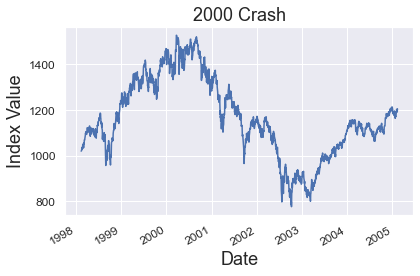

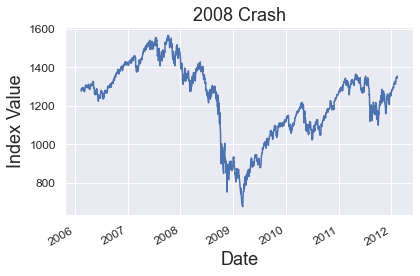

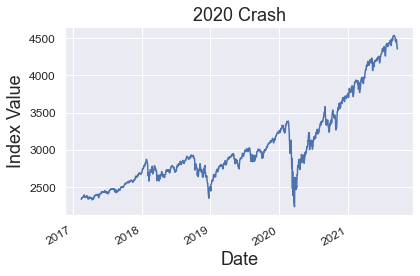

In [30]:
ticker = yf.Ticker('^GSPC')
stock = ticker.history(period="30y")

crash_1_idx = [1617, 3377]
plt.title("2000 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_1_idx[0]:crash_1_idx[1]].plot()
plt.tight_layout()
plt.savefig("2000 Crash")
plt.show()


crash_2_idx = [3629, 5140]
plt.title("2008 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_2_idx[0]:crash_2_idx[1]].plot()
plt.tight_layout()
plt.savefig("2008 Crash")
plt.show()


crash_3_idx = [6398, len(stock)]
plt.title("2020 Crash", fontsize=18)
plt.ylabel("Index Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
stock["Close"][crash_3_idx[0]:crash_3_idx[1]].plot()
plt.tight_layout()
plt.savefig("2020 Crash")
plt.show()


In [33]:
# importing the data
ticker = yf.Ticker('^GSPC')
stock = ticker.history(period="30y")
stock["Returns"] = stock["Close"].pct_change().dropna()
stock = stock.dropna()
stock["Vol"] = stock["Returns"].rolling(5).std()
stock = stock.dropna()

# setting the windows to test
windows = [800, 1000, 1250]

# storing the relevant indices of the crashes - these are the start and stop indices that correspond to the 2000, 2008, and 
# 2020 crash respectively
crash_idxs = [[1617, 3377], [3629, 5140], [6398, len(stock)]]

delay = 5
states = 2
threshold = 0.15

for j in range(0, len(windows)):
    for k in range(3):
        print("Window: ", j)
        print("Crash: ", k)
        print("\n")
        start = crash_idxs[k][0]
        end = crash_idxs[k][1]
        window = windows[j]
        price = stock[start+1:end]["Open"]
        X = log_returns(stock["Close"].values)
        signal = generate_signal_rolling(start, end, X, states, window, delay, 22)
        strat = backtest_signal(price, signal)
        print_ratios(strat, price)
        print_ann_ret(strat, price)
        #plot_highlighted_graph(price, threshold, signal, "S&P w delay (5) ret+vol Rolling window base result performance")
        print("\n\n")

Window:  0
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
-0.119 -0.168 -0.002
Asset:
Sharpe | Sortino | Calmar Ratios
0.105 0.158 0.003


Strategy Annualised Return:
-0.02
Asset Annualised Return:
0.022
Strategy Annualised Vol:
0.18
Asset Annualised Vol:
0.198



Window:  0
Crash:  1


Strategy:
Sharpe | Sortino | Calmar Ratios
0.035 0.042 0.001
Asset:
Sharpe | Sortino | Calmar Ratios
0.037 0.044 0.001


Strategy Annualised Return:
0.008
Asset Annualised Return:
0.009
Strategy Annualised Vol:
0.234
Asset Annualised Vol:
0.234



Window:  0
Crash:  2


Strategy:
Sharpe | Sortino | Calmar Ratios
0.931 0.945 0.043
Asset:
Sharpe | Sortino | Calmar Ratios
0.847 0.947 0.026


Strategy Annualised Return:
0.135
Asset Annualised Return:
0.185
Strategy Annualised Vol:
0.113
Asset Annualised Vol:
0.159



Window:  1
Crash:  0


Strategy:
Sharpe | Sortino | Calmar Ratios
-0.111 -0.155 -0.002
Asset:
Sharpe | Sortino | Calmar Ratios
0.105 0.158 0.003


Strategy Annualised Return:
-0.018
Ass

# Pre-Training Models with Mutliple Input Features (4.6-4.7)

## Data Preparation

The following data preparation functions ret_data() and create_input_df() are utilised to prepare data for feeding into the functions designed to train a model in-sample and return the model so that it can be validated on data out-of-sample. These functions which will be described in the cells below also allow for multiple ticker input data time series to be used to train the same model. 

In [13]:
def ret_data(tikka):
    """
    This function takes an input string of a ticker symbol then outputs the dataframe of the ticker from Yahoo Finance 
    with the returns and weekly rolling standard deviation calculated and added to the columns of the dataframe. 
    """
    ticker = yf.Ticker(tikka)
    data = ticker.history(period="15y")
    data["Returns"] = data["Close"].pct_change().dropna()
    data = data.dropna()
    data["Vol"] = data["Returns"].rolling(5).std()
    data = data.dropna()
    
    return data

def create_input_df(ticks):
    """
    This function takes a Python list of ticker symbols defined as STRINGS and returns a dataframe containing the returns
    of each of those tickers as the columns. The start index is the first trading day of the most recently IPO'ed company
    defined in the list of ticker strings. 
    
    This function returns a dataframe containing the returns of each of the defined tickers in "ticks" as each of the columns,
    the dataframe is also indexed by data. This is the input data required to feed into the multi_train_com() function in order
    to train it.
    """
    # creating a list of dataframes
    l = [ret_data(ticks[i]) for i in range(len(ticks))]

    # list for storing returns of each ticker
    r = []
    
    # list for storing start dates of different stocks
    d = []

    # get max date (starting)
    for i in range(len(l)):
        d.append(l[i].index[0])

    # saving index values starting on most recently floated ticker's start date
    idx = l[i].loc[d[np.argmax(d)]:].index
    
    # index values at most recent available date for all assets
    l2 = []
    for i in range(len(l)):
        l2.append(l[i].loc[d[np.argmax(d)]:])

    # make list of returns
    for i in range(len(l)):
        r.append(l2[i]["Returns"].values)
        
    # storing index in list of returns as well
    r.append(idx)  
    
    # converting list into dataframe and transposing so returns are stored as columns instead of rows
    data_in = pd.DataFrame(r).T
    
    # adding data column
    data_in.columns = ticks + ["Date"]
    
    # setting index equal to date
    data_in = data_in.set_index('Date')
    
    return data_in

## Pre-Training Models with multiple tickers for validation on any out-of-sample asset

multi_train() is a function that takes the following inputs:
- data: a dataframe containing the returns of as many tickers as desired as the columns (the direct output of the previous function: "create_input_df()"
- split: a split percentage between the train and test set samples
- seed: random seed for numpy random number generation

The multi_train() function returns: 
- model: the trained model that can now be returned and used for predicting on out-of-sample data from any asset. The main requirement is that the data predicted on must not overlap it's date index with the data used to train the model
- test.index[0]: the first date of the test index. This is returned so it can be used in later functions for knowing which value to start the test set on such that the requirement described in the above bullet point (that the out-of-sample to-be-predicted data does not overlap with the input training data)

multi_train_gen_signal() is a function that takes the following inputs:
- model: a pre-trained model (output of multi_train())
- start_idx: the starting date of the test set (output of multi_train())
- stock_to_validate: the string ticker of the stock to predict regimes on 
- delay: counter threshold- number of continous regime predictions required before regime prediction is officially changed by the algorithm
- seed: random seed for numpy random number generation

multi_train_gen_signal() returns:
- signal: generated output trading signal to be backtested on the stock_to_validate tickers next day open price
- val_stock.index[start]: this is the first day of the test set for the stock_to_validate. This value is used in the validate() function to determine where the test set starts. 

In [27]:
def multi_train(data, split, seed):
    
    # initialising seed and counter
    np.random.seed(seed)
    
    # initialising counter threshold to 0 
    count = 0
    
    # obtaining splits of data using the input "split" variable. This is for splitting the data into train and test sets
    split_val = int(split*len(data))
    train = data[:split_val]
    test = data[split_val:]

    # create the input numpy array from the pandas dataframe. data_list is a list of the values in each column of the pandas
    # dataframe. 
    data_list = [train.iloc[:, i].values for i in range(len(train.columns))]
    
    # the train values are then concatenated together 
    X_train = np.concatenate(data_list)
    
    # the numpy array is then reshaped into the format required by the HMMs - this makes the array one long array; rather than
    # a matrix with multiple columns, it becomes one long columns
    X_train = X_train.reshape(-1,1)
    
    # the HMMs require the input to be in one long column but require the lengths of each of the subsequences within that column
    # this code retrieves the lengths of each column from the train dataframe
    lengths = [len(train.iloc[:, i].values) for i in range(len(train.columns))]

    # initialise the model
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")

    # fitting the model with the training data
    model = model.fit(X_train, lengths)
    
    # returning the model, the first date of the test set (required for the backtesting function)
    return model, test.index[0]


def multi_train_gen_signal(model, start_idx, stock_to_validate, delay, seed):

    # setting random numpy seed
    np.random.seed(seed)
    
    # obtaining data for the stock to validate the model on by predicting it's out-of-sample regimes
    val_stock = ret_data(stock_to_validate)["Close"]
    
    # the numerical index of the start_index date is obtained from the stock. The "start_idx" variable corresponds to the
    # first day of the test set which is returned as the second output of the multi_train() function
    start = val_stock.index.get_loc(start_idx)
    X = log_returns(val_stock.values)
    X = X.reshape(-1, 1)

    # the following code functions the same as cash_backtest() with some minor tweaks on where the for loop begins and ends
    # the "start" variable is used to indicate the first point of the test set. 
    signal = []
    
    # the sequence fed into the model for it to predict is the entire training set up to the first day of the test set - hence,
    # the model will be predicting the regime of the first day of the test set in the following line
    predictions = model.predict(X[0:start])
    
    # same code as cash_backtest()
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    # initialising counter that counts number of consecutive regime/state predictions
    count = 0

    for i in range(1, len(X)-start):

        # on each iteration, a new day of the test set is predicted. Note: the model is never fit again in this function unlike
        # cash_backtest() where it is fit on every iteration of the for loop. 
        predictions = model.predict(X[i:start+i])
        
        # storing the latest prediction as a temporary variable pred
        pred = predictions[-1]

        # applying the counter threshold algorithm: if pred is same as the previous pred, increment counter by 1
        if pred == prev_pred:
            count = count + 1 
            
        # if pred is not the same as previous pred, reset counter to 1
        elif pred != prev_pred:
            count = 1
        
        # if counter is greater than threshold value, append the new continous prediction to the signal vector
        if count >= delay:
            signal.append(pred)
        
        # if counter is less than the threshold value, append the signal value to the signal again and extend the predictions
        # of the current regime
        elif count < delay:
            signal.append(signal[-1])

        prev_pred = pred

    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)

    else: 
        signal = np.array(signal)

    return signal, val_stock.index[start]


def validate(tikka, s, start_idx):
    """Function that takes the following inputs:
    - tikka: string of ticker to validate the pre-trained model's signal on
    - s: pre-trained models signal
    - start_idx: first date of the test set that the signal needs to be traded on
    """
    
    # retrieves next day open data - the next day is in relation to the first day of the test set. The initial information 
    # obtained from the signal is obtained on the close of the first day of the test set and can only be applied to the next
    # day's open
    trial_price = ret_data(tikka)["Open"].loc[start_idx:][1:]
    
    # backtesting the signal
    strat = backtest_signal(trial_price, s)
    
    # suite of performance metrics to call
    print_ratios(strat, trial_price)
    print_ann_ret(strat, trial_price)
    
    return

# Method 3 - Pre-Training a Model on the Tickers from a Sector (Real Estate) and predicting the S&P500 out-of-sample (Method 4.6-4.7 of the Thesis)

Strategy:
Sharpe | Sortino | Calmar Ratios
0.894 1.06 0.041
Asset:
Sharpe | Sortino | Calmar Ratios
0.77 0.901 0.026


Strategy Annualised Return:
0.161
Asset Annualised Return:
0.169
Strategy Annualised Vol:
0.143
Asset Annualised Vol:
0.172


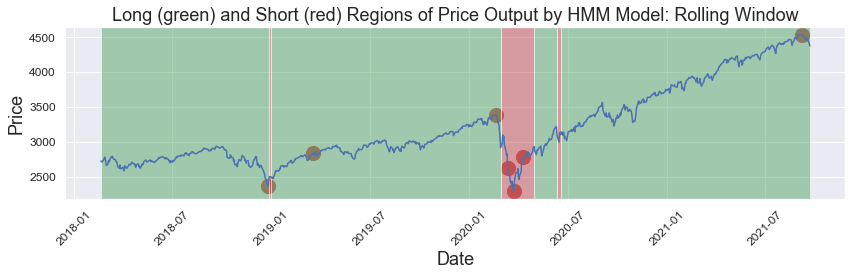

In [29]:
# importing csv containing sector tickers
df_re = pd.read_csv("real-estate.csv")

# retrieving the names of the tickers only as a list of strings
ticks_re = list(df_re["Symbol"][0:-1].values)

# using the list of strings as an input into the create_input_df() function to retrieve the price data from Yahoo and calculate
# the required return data within the create_input_df() function
data_re = create_input_df(ticks_re)

# initialising the general parameters
split = 0.76
delay = 2
seed = 22
threshold = 0.2
stock_to_validate = "^GSPC"

# obtained the pre-trained model 
model, start_idx = multi_train(data_re, split, seed)

# generating a trading signal "s" from the pre-trained model 
s, start = multi_train_gen_signal(model, start_idx, stock_to_validate, delay, seed)

# validating the signal on the S&P500 out-of-sample
validate(stock_to_validate, s, start)

# obtaining the relevant next day open price so that it can be plotted using the plot_highlighted_graph() function
trial_price = ret_data(stock_to_validate)["Open"].loc[start:][1:]
plot_highlighted_graph(trial_price, threshold, s, "Real Estate to Predict S&P500")